In [1]:
import sys
sys.path.append('../')

In [2]:
import game.agent as ag
from game.run import run
from game.simulator import load_simulator_yarn, GraphSimulator
from pathlib import Path
from tqdm.auto import trange
import pandas as pd
# import itertools
import mpire

In [3]:
n_runs = int(1e3)
seed = None

In [4]:
simulator = load_simulator_yarn('../yarnScripts')

In [5]:
def get_agent():
    return ag.RandomAgent(None)
    # return ag.TorchRAgent(
    #     model_path=Path('./models/tmp/saved_good/adamw_max_val_acc_8_False_125,[20],[20]_0.001'),
    #     rand=0,
# )

In [8]:
df = run(get_agent, simulator, n_runs)

100%|██████████| 1000/1000 [00:00<00:00, 1828.05it/s]


In [9]:
print(df)

            title kind
0      MaloAmigos    0
1    MaloSilencio    0
2      MaloAmanda    0
3      MaloAmigos    0
4    MaloSilencio    0
..            ...  ...
995    MaloAmigos    0
996    MaloAmigos    0
997  MaloSilencio    0
998  MaloSilencio    0
999    MaloAmigos    0

[1000 rows x 2 columns]


In [10]:
df.to_csv('endings.csv')

In [ ]:
df['kind'].value_counts(normalize=True)

<AxesSubplot:>

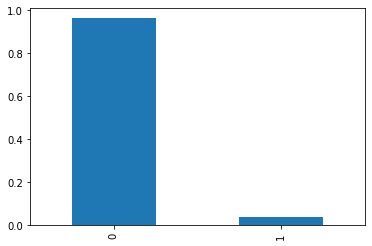

In [12]:
df['kind'].value_counts(normalize=True).plot.bar()

# Multiprocessing (does not work)

In [ ]:
def init_func(worker_state):
    # Initialize a counter for each worker
    worker_state['count_even'] = 0
    pass

def square_and_count_even(worker_state, x):
    # Count number of even numbers and return the square
    if x % 2 == 0:
        worker_state['count_even'] += 1
    return x * x
    pass

def exit_func(worker_state):
    # Return the counter
    return worker_state['count_even']
    pass

with mpire.WorkerPool(n_jobs=4, use_worker_state=True, start_method="spawn") as pool:
    pool.map(square_and_count_even, range(100), worker_init=init_func, worker_exit=exit_func, progress_bar=True)
    print(pool.get_exit_results())  # Output, e.g.: [13, 13, 12, 12]
    print(sum(pool.get_exit_results()))  # Output: 50
